Same as velocity_overview_figure, but a figure
for Ed's PTM manuscript, showing flow at time of tag
7B4D transiting.

In [1]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import glob
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates, collections
from matplotlib import cm
from matplotlib import patches

from shapely import geometry

from stompy import utils, memoize, filters,xr_utils, xr_transect
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.model.fish_ptm import ptm_tools

from stompy.spatial import field, proj_utils, wkb2shp
from stompy.model import data_comparison
%matplotlib notebook
turbo=scmap.load_gradient('turbo.cpt')

In [2]:
# dem=field.GdalGrid("../../bathy/junction-composite-20190117-no_adcp.tif")
dem=field.GdalGrid("../../bathy/junction-composite-20200604-w_smooth.tif")

Velocity overview figure
---

In [3]:
if 0: # omit ADCP transects for this figure
    adcp_transects=wkb2shp.shp2geom("../../gis/model_transects.shp")
    trans=[t['name'].startswith('2018') for t in adcp_transects]
    sel_adcp_transects=adcp_transects[trans]
else:
    sel_adcp_transects=[]

In [4]:
# zoom=(647100., 647456., 4185649., 4185974.)
zoom=(647066, 647547., 4185592., 4185997.)
demc=dem.crop([647000,647550,4.185550e6,4.186070e6])

cmap=turbo

In [5]:
aerial=field.GdalGrid('../../gis/aerial/m_3712114_sw_10_h_20160621_20161004-UTM-crop.tif',
                     geo_bounds=zoom)
aerial.F=aerial.F[:,:,:3] # drop alpha - seems mis-scaled

Putting multiple channels as last index


Streamline Tracer Approach
--

In [6]:
def prep_model_data(avg_nc,t_idx):
    avg_snap=avg_nc.isel(time=t_idx)
    g=unstructured_grid.UnstructuredGrid.read_ugrid(avg_snap)
    c2e=g.cells['edges']
    c2e[ c2e==999999 ] = -1
    
    # Vertical integration on the average output:
    from stompy.grid import ugrid
    ug=ugrid.UgridXr(avg_nc,face_eta_vname='eta')
    for v in ['dv','z_r','z_w']:
        avg_nc[v].attrs['positive']='down'
    # had been depth average, with zbottom=0
    weights=ug.vertical_averaging_weights(time_slice=t_idx,ztop=0,dz=2)
    U=avg_nc.uc.isel(time=t_idx).values.T
    V=avg_nc.vc.isel(time=t_idx).values.T
    Udavg=np.nansum( U * weights, axis=1)
    Vdavg=np.nansum( V * weights, axis=1)

    Uc=np.c_[ Udavg, Vdavg]
    return g,Uc


In [7]:
from stompy.grid import exact_delaunay
from stompy.model import stream_tracer
six.moves.reload_module(unstructured_grid)
six.moves.reload_module(exact_delaunay)
six.moves.reload_module(stream_tracer)

<module 'stompy.model.stream_tracer' from '/home/rustyh/src/stompy/stompy/model/stream_tracer.py'>

In [8]:
# When did 7B4D transit?
track=pd.read_csv("../../field/hor_yaps/screen_final/track-7B4D.csv")
# track.time_m.values[ [0,-2] ]
target_time=utils.unix_to_dt64(track.tnum.mean())
target_time

numpy.datetime64('2018-03-19T04:26:19.333409')

In [9]:
df_master=pd.read_csv("../../field/hor_yaps/screen_final/master.csv")
track_meta=df_master[ df_master['id']=='7B4D'].iloc[0]
track_meta

id                                  7B4D
basename                  track-7B4D.csv
num_positions                        133
duration_s                       1469.94
top_of_array_first           1.52143e+09
top_of_array_last            1.52143e+09
top_of_array_uncrossed                 0
middle_first                 1.52143e+09
middle_last                  1.52143e+09
middle_uncrossed                       0
sj_lower_first                       NaN
sj_lower_last                        NaN
sj_lower_uncrossed                     0
hor_lower_first              1.52143e+09
hor_lower_last               1.52143e+09
hor_lower_uncrossed                    0
hor_upper_first              1.52143e+09
hor_upper_last               1.52143e+09
hor_upper_uncrossed                    0
sj_upper_first                       NaN
sj_upper_last                        NaN
sj_upper_uncrossed                     0
rms_pos_error                    1.56273
track_fn                  track-7B4D.csv
Name: 103, dtype

In [32]:
# Go back to real data:
# model=sun_driver.SuntansModel.load('runs/short045_g8.24_20180405')
# What a pain.. avg_nc has cell-center velocities already calculated,
# while ptm_avg has volumes already calculated.

# min_clearance=2 was too close..
# 4,8 was close, but left a few short ones...

from stompy.plot import stream_quiver
six.moves.reload_module(stream_quiver)

kws=dict(min_clearance=4,
         seed_clearance=8,
         max_t=40.,
         max_dist=60.,
         pack=True)

# 7B4D transit
avg_fn='runs/cfg012_farm12_20180320/average.nc_0000.nc'
avg_nc=xr.open_dataset(avg_fn)
t_idx = np.searchsorted( avg_nc.time.values, target_time)
g,Uc=prep_model_data(avg_nc,t_idx)
# Was 1500...
sq_highflow=stream_quiver.StreamlineQuiver(g,Uc,streamline_count=1500,**kws)

INFO:join_features:0 open strings, 1 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=152841.432267, 0 potential interiors


****************

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:2758: RuntimeWarning: divide by zero encountered in true_divide
  cxy[valid] /= 6*A[valid,None]


***********************************************************************************************************************************************************************************************************.***************.*************************************************.**************************************************************.******************************************************.***-********.****.********.****************************-****.****.*-*********.****.*-***********.********-*****-***-**.******.*****-*.******-**.**-*****.*-**.********-****.*.****.***.***-*-*****-**-*****-*-*-*.****-***-***-***-****-***.*-***.**-*-*.*-***-**.****-****.**.**-*-*.*-***-****-***-*-**-**-*********-*.**-*-**-*-****.***-*********-*-*-*.********.**-*-***.*-*-*****-**-**!
*.Stopping on seed clearance


/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:2758: RuntimeWarning: invalid value encountered in true_divide
  cxy[valid] /= 6*A[valid,None]


<IPython.core.display.Javascript object>


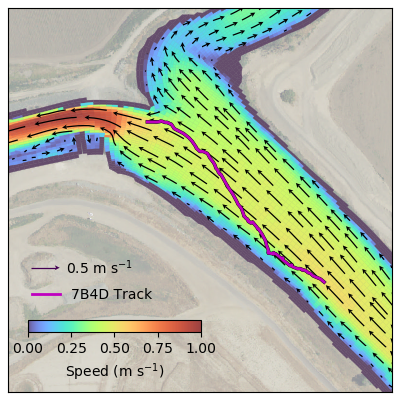

In [43]:
clim=[0,1.00]
# Shift some contrast to the lower end
cmap=scmap.cmap_transform(turbo,lambda x: x**0.75)

fade=0.75
cmap=scmap.transform_color(lambda x: fade*x + (1-fade), cmap)

class QuiverPlotWithBackground(object):
    bathy_contour=False
    legend=True
    cbar=True
    
    ax=None
    dV=1.0 # interval for contours
    sq=None # Stream quiver instance
    include_truncated=False

    zoom=(647076.5624255964, 647510.026008116, 4185590.120652568, 4185998.7323230235)

    cax_rel=[0.03,0.15,0.45,0.03]
    leg_loc=[0.048,0.22]

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        if self.ax is None:
            self.ax=plt.gca()
        self.plot()
    def add_bathy_contour(self):
        demc.contour(np.arange(-10,6,self.dV),ax=self.ax,
                     cmap='gray_r',linewidths=0.2,
                     zorder=-1)

    def fmt_axes(self):
        ax=self.ax
        ax.set_adjustable('datalim')
        ax.axis('equal')
        ax.yaxis.set_visible(0)
        ax.xaxis.set_visible(0)

    def plot(self):
        self.fmt_axes()
        if self.bathy_contour:
            self.add_bathy_contour()
        self.quiver=self.sq.plot_quiver(ax=self.ax,
                                        include_truncated=self.include_truncated)
        self.plot_adcp()
        self.adjust_quiver(self.quiver)
        self.plot_speed()
        self.plot_aerial()
        self.ax.axis(self.zoom)

    def plot_adcp(self):
        if not sel_adcp_transects:
            return
        # And show the ADCP transect locations, too.
        for t in sel_adcp_transects:
            name=int(t['name'].replace('2018_',''))
            xy=np.array(t['geom'])
            l=self.ax.plot(xy[:,0],xy[:,1],color='k',ls='--',lw=0.75)
            plot_utils.annotate_line(l[0],name,ax=self.ax,norm_position=0.0,rotation=None,
                                    offset_points=5)
        if self.legend:
            self.ax.legend([l[0]],["ADCP Transect"],
                           loc=self.leg_loc,frameon=0)
    def adjust_quiver(self,quiver):
        # black arrows, color in background for speed
        for coll in [quiver['lcoll'],
                     quiver['pcoll']]:
            coll.set_array(None)
            coll.set_color('k')

    def plot_speed(self):
        ccoll=self.sq.g.plot_cells(values=self.sq.Umag,cmap=cmap,clim=clim,ax=self.ax,zorder=-2)
        ccoll.set_edgecolor('face')
        ccoll.set_lw(0.2)
        if self.cbar:
            box=self.ax.get_position()
            self.cax=fig.add_axes([box.xmin+self.cax_rel[0],
                                   box.ymin+self.cax_rel[1],
                                   box.width*self.cax_rel[2], 
                                   box.height*self.cax_rel[3]])
            plt.colorbar(ccoll,cax=self.cax,label='Speed (m s$^{-1}$)',orientation='horizontal')
    def plot_aerial(self):
        # add aerial image in backgroud
        aerial.plot(ax=self.ax,zorder=-3,alpha=0.5)

        
fig,ax=plt.subplots(1,1,figsize=[4.0, 4.0])
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02,wspace=0.02)

sq_highflow.lw=0.9
sq_highflow.sym=1.2 * stream_quiver.StreamlineQuiver.sym

q1=QuiverPlotWithBackground(ax=ax,sq=sq_highflow,cax_rel=[0.05,0.15,0.45,0.03])

track_sel=( (track.tnum>track_meta['top_of_array_first']) 
           & (track.tnum<=track_meta['hor_lower_first'])).values
track_sel=slice(None)
tx=track.x[track_sel]
ty=track.y[track_sel]
ax.plot(tx, ty, 'k-', lw=2.5)
ax.plot(tx, ty, 'm-', lw=2,label="7B4D Track")

ax.legend(loc=q1.leg_loc,frameon=0)
ax.axis( (647068.7169947602, 647445.2080819, 4185594.6284124237, 4185971.1194995632) )

# Location here is janky. Would like to tie it in with the axes coordinates
# of the legend, but 
leg_xy=ax.transData.inverted().transform( ax.transAxes.transform( q1.leg_loc) )
result=sq_highflow.quiverkey(X=leg_xy[0]+4, # still have to tune these...
                             Y=leg_xy[1]+39,
                             U=0.5,label="0.5 m s$^{-1}$",ax=ax)

fig.savefig('velocity-overview-7B4D.png',dpi=200)

array([ 647086.78856694, 4185677.45645159])